<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:14:17] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


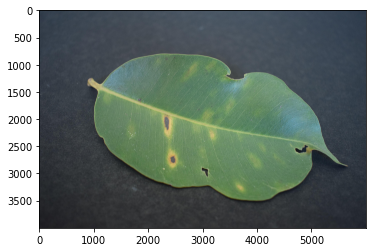

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

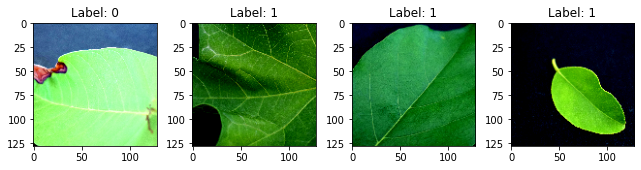

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[16:14:25] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:14:27] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2627183536839335 samples/sec                   batch loss = 0.4568111300468445 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2650017496565342 samples/sec                   batch loss = 0.7390302419662476 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2736940135481887 samples/sec                   batch loss = 0.6089887022972107 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2747982760469194 samples/sec                   batch loss = 0.9343466758728027 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2698459409163285 samples/sec                   batch loss = 1.0289289951324463 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2503327383454756 samples/sec                   batch loss = 0.7483688592910767 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.2615725818246404 samples/sec                   batch loss = 2.993576765060425 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.2608425464137318 samples/sec                   batch loss = 0.8344545364379883 | accuracy = 0.525


Epoch[1] Batch[45] Speed: 1.2606405612659892 samples/sec                   batch loss = 0.9359933733940125 | accuracy = 0.5277777777777778


Epoch[1] Batch[50] Speed: 1.2590004579079626 samples/sec                   batch loss = 1.343024492263794 | accuracy = 0.535


Epoch[1] Batch[55] Speed: 1.2544469785952692 samples/sec                   batch loss = 0.6131332516670227 | accuracy = 0.5318181818181819


Epoch[1] Batch[60] Speed: 1.2669836262391294 samples/sec                   batch loss = 0.8652270436286926 | accuracy = 0.5291666666666667


Epoch[1] Batch[65] Speed: 1.2681383897064498 samples/sec                   batch loss = 0.5255876183509827 | accuracy = 0.5192307692307693


Epoch[1] Batch[70] Speed: 1.2703997933099702 samples/sec                   batch loss = 0.7539552450180054 | accuracy = 0.5321428571428571


Epoch[1] Batch[75] Speed: 1.2611334163804968 samples/sec                   batch loss = 0.44006815552711487 | accuracy = 0.5366666666666666


Epoch[1] Batch[80] Speed: 1.2694834100623027 samples/sec                   batch loss = 0.5862078666687012 | accuracy = 0.5375


Epoch[1] Batch[85] Speed: 1.2675759721703528 samples/sec                   batch loss = 0.42866945266723633 | accuracy = 0.5323529411764706


Epoch[1] Batch[90] Speed: 1.268750813424643 samples/sec                   batch loss = 0.5773378610610962 | accuracy = 0.5333333333333333


Epoch[1] Batch[95] Speed: 1.2652496937406656 samples/sec                   batch loss = 0.5237434506416321 | accuracy = 0.5394736842105263


Epoch[1] Batch[100] Speed: 1.261213715952949 samples/sec                   batch loss = 0.6752540469169617 | accuracy = 0.55


Epoch[1] Batch[105] Speed: 1.2643383406324942 samples/sec                   batch loss = 0.5396252870559692 | accuracy = 0.5547619047619048


Epoch[1] Batch[110] Speed: 1.2651373961338737 samples/sec                   batch loss = 0.4130469858646393 | accuracy = 0.5613636363636364


Epoch[1] Batch[115] Speed: 1.266682496533599 samples/sec                   batch loss = 0.6846142411231995 | accuracy = 0.5608695652173913


Epoch[1] Batch[120] Speed: 1.2713843611354998 samples/sec                   batch loss = 0.35004571080207825 | accuracy = 0.5645833333333333


Epoch[1] Batch[125] Speed: 1.2618282939822765 samples/sec                   batch loss = 0.6318749189376831 | accuracy = 0.57


Epoch[1] Batch[130] Speed: 1.2627066642311502 samples/sec                   batch loss = 0.6358897686004639 | accuracy = 0.573076923076923


Epoch[1] Batch[135] Speed: 1.264969320911656 samples/sec                   batch loss = 0.6901811361312866 | accuracy = 0.575925925925926


Epoch[1] Batch[140] Speed: 1.2626417584428908 samples/sec                   batch loss = 0.2990944981575012 | accuracy = 0.575


Epoch[1] Batch[145] Speed: 1.265361056931313 samples/sec                   batch loss = 0.8650001883506775 | accuracy = 0.5741379310344827


Epoch[1] Batch[150] Speed: 1.261911054956696 samples/sec                   batch loss = 0.6566515564918518 | accuracy = 0.5783333333333334


Epoch[1] Batch[155] Speed: 1.266167139457568 samples/sec                   batch loss = 0.46137121319770813 | accuracy = 0.5838709677419355


Epoch[1] Batch[160] Speed: 1.269025953996151 samples/sec                   batch loss = 0.47154125571250916 | accuracy = 0.5890625


Epoch[1] Batch[165] Speed: 1.2653376757154078 samples/sec                   batch loss = 0.47680115699768066 | accuracy = 0.5924242424242424


Epoch[1] Batch[170] Speed: 1.259818793277789 samples/sec                   batch loss = 0.4321219027042389 | accuracy = 0.5955882352941176


Epoch[1] Batch[175] Speed: 1.2618475596158323 samples/sec                   batch loss = 0.22962211072444916 | accuracy = 0.6028571428571429


Epoch[1] Batch[180] Speed: 1.2712280107549492 samples/sec                   batch loss = 1.2991341352462769 | accuracy = 0.6027777777777777


Epoch[1] Batch[185] Speed: 1.2737542582566714 samples/sec                   batch loss = 0.42913341522216797 | accuracy = 0.6040540540540541


Epoch[1] Batch[190] Speed: 1.2679917489769925 samples/sec                   batch loss = 0.4706767499446869 | accuracy = 0.6065789473684211


Epoch[1] Batch[195] Speed: 1.2667163521334008 samples/sec                   batch loss = 0.3382645845413208 | accuracy = 0.6115384615384616


Epoch[1] Batch[200] Speed: 1.274020641040478 samples/sec                   batch loss = 0.7217546701431274 | accuracy = 0.61


Epoch[1] Batch[205] Speed: 1.2772300307575748 samples/sec                   batch loss = 0.27022621035575867 | accuracy = 0.6121951219512195


Epoch[1] Batch[210] Speed: 1.2710249956949953 samples/sec                   batch loss = 1.144700050354004 | accuracy = 0.6071428571428571


Epoch[1] Batch[215] Speed: 1.274043860504435 samples/sec                   batch loss = 0.4797632098197937 | accuracy = 0.6093023255813953


Epoch[1] Batch[220] Speed: 1.271489386985852 samples/sec                   batch loss = 0.7907332181930542 | accuracy = 0.6113636363636363


Epoch[1] Batch[225] Speed: 1.2668284519498239 samples/sec                   batch loss = 0.2953311502933502 | accuracy = 0.6144444444444445


Epoch[1] Batch[230] Speed: 1.2760435174142672 samples/sec                   batch loss = 0.2814289331436157 | accuracy = 0.6173913043478261


Epoch[1] Batch[235] Speed: 1.2707275243672898 samples/sec                   batch loss = 0.4369707703590393 | accuracy = 0.6191489361702127


Epoch[1] Batch[240] Speed: 1.2721502915095204 samples/sec                   batch loss = 0.46455857157707214 | accuracy = 0.6197916666666666


Epoch[1] Batch[245] Speed: 1.2612194046221965 samples/sec                   batch loss = 0.4995473623275757 | accuracy = 0.6224489795918368


Epoch[1] Batch[250] Speed: 1.2720176698774142 samples/sec                   batch loss = 1.0164002180099487 | accuracy = 0.625


Epoch[1] Batch[255] Speed: 1.2699812824564152 samples/sec                   batch loss = 0.8027896285057068 | accuracy = 0.6264705882352941


Epoch[1] Batch[260] Speed: 1.2762827019934615 samples/sec                   batch loss = 0.42680391669273376 | accuracy = 0.6307692307692307


Epoch[1] Batch[265] Speed: 1.2745085244052288 samples/sec                   batch loss = 0.325174480676651 | accuracy = 0.629245283018868


Epoch[1] Batch[270] Speed: 1.2735579762401792 samples/sec                   batch loss = 1.1516664028167725 | accuracy = 0.6314814814814815


Epoch[1] Batch[275] Speed: 1.2694369196261637 samples/sec                   batch loss = 0.4357087016105652 | accuracy = 0.6354545454545455


Epoch[1] Batch[280] Speed: 1.2675827718551138 samples/sec                   batch loss = 0.409126877784729 | accuracy = 0.6366071428571428


Epoch[1] Batch[285] Speed: 1.2747563352530287 samples/sec                   batch loss = 0.5001747012138367 | accuracy = 0.637719298245614


Epoch[1] Batch[290] Speed: 1.2740094186029558 samples/sec                   batch loss = 0.440037339925766 | accuracy = 0.6431034482758621


Epoch[1] Batch[295] Speed: 1.2740549867975217 samples/sec                   batch loss = 1.2077000141143799 | accuracy = 0.6457627118644068


Epoch[1] Batch[300] Speed: 1.277075447339832 samples/sec                   batch loss = 0.8974502682685852 | accuracy = 0.6466666666666666


Epoch[1] Batch[305] Speed: 1.273892852389101 samples/sec                   batch loss = 0.46360182762145996 | accuracy = 0.648360655737705


Epoch[1] Batch[310] Speed: 1.2748980539228505 samples/sec                   batch loss = 0.5821340680122375 | accuracy = 0.6475806451612903


Epoch[1] Batch[315] Speed: 1.2750197459462578 samples/sec                   batch loss = 1.000948190689087 | accuracy = 0.6484126984126984


Epoch[1] Batch[320] Speed: 1.2672001875586214 samples/sec                   batch loss = 0.41851019859313965 | accuracy = 0.64765625


Epoch[1] Batch[325] Speed: 1.2713954410257666 samples/sec                   batch loss = 0.6040797829627991 | accuracy = 0.6515384615384615


Epoch[1] Batch[330] Speed: 1.2766077445119015 samples/sec                   batch loss = 0.7306291460990906 | accuracy = 0.6515151515151515


Epoch[1] Batch[335] Speed: 1.2734899201500143 samples/sec                   batch loss = 0.7286065816879272 | accuracy = 0.6522388059701493


Epoch[1] Batch[340] Speed: 1.2634976632334445 samples/sec                   batch loss = 0.866580069065094 | accuracy = 0.6544117647058824


Epoch[1] Batch[345] Speed: 1.2698302746891277 samples/sec                   batch loss = 0.9773027300834656 | accuracy = 0.6543478260869565


Epoch[1] Batch[350] Speed: 1.272317771851949 samples/sec                   batch loss = 0.5917460918426514 | accuracy = 0.6521428571428571


Epoch[1] Batch[355] Speed: 1.2713009309467505 samples/sec                   batch loss = 1.4358593225479126 | accuracy = 0.6514084507042254


Epoch[1] Batch[360] Speed: 1.2718478581158534 samples/sec                   batch loss = 0.6607956290245056 | accuracy = 0.65


Epoch[1] Batch[365] Speed: 1.2635449567529309 samples/sec                   batch loss = 0.49413228034973145 | accuracy = 0.6506849315068494


Epoch[1] Batch[370] Speed: 1.263683146433359 samples/sec                   batch loss = 2.123095750808716 | accuracy = 0.6513513513513514


Epoch[1] Batch[375] Speed: 1.2650799669999124 samples/sec                   batch loss = 0.3955192565917969 | accuracy = 0.652


Epoch[1] Batch[380] Speed: 1.2700559825778148 samples/sec                   batch loss = 0.3884449601173401 | accuracy = 0.6532894736842105


Epoch[1] Batch[385] Speed: 1.2628797472737445 samples/sec                   batch loss = 0.36726105213165283 | accuracy = 0.6551948051948052


Epoch[1] Batch[390] Speed: 1.259512643874213 samples/sec                   batch loss = 0.8800339698791504 | accuracy = 0.6557692307692308


Epoch[1] Batch[395] Speed: 1.2600916819998254 samples/sec                   batch loss = 0.5286030769348145 | accuracy = 0.6569620253164556


Epoch[1] Batch[400] Speed: 1.2619990478525194 samples/sec                   batch loss = 0.7051911354064941 | accuracy = 0.6575


Epoch[1] Batch[405] Speed: 1.2655406916595855 samples/sec                   batch loss = 0.4641553461551666 | accuracy = 0.6567901234567901


Epoch[1] Batch[410] Speed: 1.2625748639985743 samples/sec                   batch loss = 0.7224825620651245 | accuracy = 0.6567073170731708


Epoch[1] Batch[415] Speed: 1.255670521446452 samples/sec                   batch loss = 0.6567556858062744 | accuracy = 0.6566265060240963


Epoch[1] Batch[420] Speed: 1.2624111735457044 samples/sec                   batch loss = 0.5763489603996277 | accuracy = 0.6577380952380952


Epoch[1] Batch[425] Speed: 1.2579233832027514 samples/sec                   batch loss = 0.7015730738639832 | accuracy = 0.658235294117647


Epoch[1] Batch[430] Speed: 1.2763601844045507 samples/sec                   batch loss = 0.28267452120780945 | accuracy = 0.661046511627907


Epoch[1] Batch[435] Speed: 1.2624216226254465 samples/sec                   batch loss = 0.7205707430839539 | accuracy = 0.6620689655172414


Epoch[1] Batch[440] Speed: 1.272066857220238 samples/sec                   batch loss = 0.7440984845161438 | accuracy = 0.6619318181818182


Epoch[1] Batch[445] Speed: 1.2709034873454805 samples/sec                   batch loss = 0.32386624813079834 | accuracy = 0.6640449438202247


Epoch[1] Batch[450] Speed: 1.273514570308417 samples/sec                   batch loss = 0.8569238781929016 | accuracy = 0.6633333333333333


Epoch[1] Batch[455] Speed: 1.272248401084093 samples/sec                   batch loss = 0.5473565459251404 | accuracy = 0.6642857142857143


Epoch[1] Batch[460] Speed: 1.2630261587666 samples/sec                   batch loss = 0.5516036748886108 | accuracy = 0.6641304347826087


Epoch[1] Batch[465] Speed: 1.2647673463393798 samples/sec                   batch loss = 0.6805495023727417 | accuracy = 0.6634408602150538


Epoch[1] Batch[470] Speed: 1.2707766119821398 samples/sec                   batch loss = 0.6599479913711548 | accuracy = 0.6638297872340425


Epoch[1] Batch[475] Speed: 1.2738341420510644 samples/sec                   batch loss = 0.38482657074928284 | accuracy = 0.6652631578947369


Epoch[1] Batch[480] Speed: 1.274483642121518 samples/sec                   batch loss = 0.2676584720611572 | accuracy = 0.6645833333333333


Epoch[1] Batch[485] Speed: 1.2624413813581112 samples/sec                   batch loss = 0.7299273610115051 | accuracy = 0.6649484536082474


Epoch[1] Batch[490] Speed: 1.2693327127349496 samples/sec                   batch loss = 0.25794997811317444 | accuracy = 0.6653061224489796


Epoch[1] Batch[495] Speed: 1.2756790886824687 samples/sec                   batch loss = 0.8677065372467041 | accuracy = 0.6641414141414141


Epoch[1] Batch[500] Speed: 1.274395835756138 samples/sec                   batch loss = 0.39485469460487366 | accuracy = 0.664


Epoch[1] Batch[505] Speed: 1.2745116226564333 samples/sec                   batch loss = 0.1848987638950348 | accuracy = 0.6663366336633664


Epoch[1] Batch[510] Speed: 1.263732548011916 samples/sec                   batch loss = 0.5076009035110474 | accuracy = 0.6661764705882353


Epoch[1] Batch[515] Speed: 1.2763205681618832 samples/sec                   batch loss = 0.5048481822013855 | accuracy = 0.6679611650485436


Epoch[1] Batch[520] Speed: 1.270023967164054 samples/sec                   batch loss = 0.3123203217983246 | accuracy = 0.66875


Epoch[1] Batch[525] Speed: 1.2726846267866436 samples/sec                   batch loss = 0.2613460123538971 | accuracy = 0.67


Epoch[1] Batch[530] Speed: 1.269216808671566 samples/sec                   batch loss = 0.929102897644043 | accuracy = 0.6693396226415095


Epoch[1] Batch[535] Speed: 1.270235221790496 samples/sec                   batch loss = 0.790193498134613 | accuracy = 0.6700934579439253


Epoch[1] Batch[540] Speed: 1.2768084658990289 samples/sec                   batch loss = 0.6759928464889526 | accuracy = 0.6717592592592593


Epoch[1] Batch[545] Speed: 1.2711418081090788 samples/sec                   batch loss = 0.661521315574646 | accuracy = 0.6711009174311927


Epoch[1] Batch[550] Speed: 1.271058120859805 samples/sec                   batch loss = 0.7033331990242004 | accuracy = 0.6718181818181819


Epoch[1] Batch[555] Speed: 1.2653115279505278 samples/sec                   batch loss = 0.8703655004501343 | accuracy = 0.6725225225225225


Epoch[1] Batch[560] Speed: 1.2632216805413208 samples/sec                   batch loss = 0.45073580741882324 | accuracy = 0.671875


Epoch[1] Batch[565] Speed: 1.2656612721538794 samples/sec                   batch loss = 0.5259733200073242 | accuracy = 0.6716814159292035


Epoch[1] Batch[570] Speed: 1.264975520396101 samples/sec                   batch loss = 0.4170975685119629 | accuracy = 0.6723684210526316


Epoch[1] Batch[575] Speed: 1.2640416096918503 samples/sec                   batch loss = 0.7992161512374878 | accuracy = 0.672608695652174


Epoch[1] Batch[580] Speed: 1.2630010572425632 samples/sec                   batch loss = 1.8997654914855957 | accuracy = 0.6732758620689655


Epoch[1] Batch[585] Speed: 1.2604798341600438 samples/sec                   batch loss = 0.5463936924934387 | accuracy = 0.6735042735042736


Epoch[1] Batch[590] Speed: 1.270938531743624 samples/sec                   batch loss = 0.42546147108078003 | accuracy = 0.675


Epoch[1] Batch[595] Speed: 1.2668365828276347 samples/sec                   batch loss = 0.6056150794029236 | accuracy = 0.6743697478991597


Epoch[1] Batch[600] Speed: 1.2616426907257785 samples/sec                   batch loss = 1.477164387702942 | accuracy = 0.6745833333333333


Epoch[1] Batch[605] Speed: 1.2616289339669797 samples/sec                   batch loss = 0.38221490383148193 | accuracy = 0.675206611570248


Epoch[1] Batch[610] Speed: 1.265108394723517 samples/sec                   batch loss = 0.6660324335098267 | accuracy = 0.6745901639344263


Epoch[1] Batch[615] Speed: 1.263012181658517 samples/sec                   batch loss = 0.5895406007766724 | accuracy = 0.6747967479674797


Epoch[1] Batch[620] Speed: 1.264970751556519 samples/sec                   batch loss = 0.5623579621315002 | accuracy = 0.6745967741935484


Epoch[1] Batch[625] Speed: 1.2555543739644917 samples/sec                   batch loss = 0.5464820861816406 | accuracy = 0.6744


Epoch[1] Batch[630] Speed: 1.2648926430819285 samples/sec                   batch loss = 0.24798953533172607 | accuracy = 0.675


Epoch[1] Batch[635] Speed: 1.2697928887518475 samples/sec                   batch loss = 0.6770215630531311 | accuracy = 0.6751968503937008


Epoch[1] Batch[640] Speed: 1.2746811780555563 samples/sec                   batch loss = 0.642245888710022 | accuracy = 0.675


Epoch[1] Batch[645] Speed: 1.2716096580757883 samples/sec                   batch loss = 1.0267196893692017 | accuracy = 0.6748062015503876


Epoch[1] Batch[650] Speed: 1.2658365032910797 samples/sec                   batch loss = 0.37797918915748596 | accuracy = 0.6765384615384615


Epoch[1] Batch[655] Speed: 1.2671788439371934 samples/sec                   batch loss = 0.5046330690383911 | accuracy = 0.6770992366412214


Epoch[1] Batch[660] Speed: 1.269650669314557 samples/sec                   batch loss = 0.3608182668685913 | accuracy = 0.6776515151515151


Epoch[1] Batch[665] Speed: 1.2702811936446325 samples/sec                   batch loss = 0.5207408666610718 | accuracy = 0.6789473684210526


Epoch[1] Batch[670] Speed: 1.2629497163236314 samples/sec                   batch loss = 0.3634198307991028 | accuracy = 0.6798507462686567


Epoch[1] Batch[675] Speed: 1.2618705272974424 samples/sec                   batch loss = 0.6567249894142151 | accuracy = 0.6807407407407408


Epoch[1] Batch[680] Speed: 1.2686347278103882 samples/sec                   batch loss = 0.7322745323181152 | accuracy = 0.6816176470588236


Epoch[1] Batch[685] Speed: 1.2698593968801841 samples/sec                   batch loss = 0.28195956349372864 | accuracy = 0.6821167883211678


Epoch[1] Batch[690] Speed: 1.2740511167604935 samples/sec                   batch loss = 0.4909491240978241 | accuracy = 0.6826086956521739


Epoch[1] Batch[695] Speed: 1.2707341654109963 samples/sec                   batch loss = 0.24604812264442444 | accuracy = 0.6841726618705036


Epoch[1] Batch[700] Speed: 1.2686814473172388 samples/sec                   batch loss = 0.4352025091648102 | accuracy = 0.6842857142857143


Epoch[1] Batch[705] Speed: 1.2567729240497785 samples/sec                   batch loss = 0.11750636994838715 | accuracy = 0.6851063829787234


Epoch[1] Batch[710] Speed: 1.252942887988333 samples/sec                   batch loss = 0.9320597648620605 | accuracy = 0.6852112676056338


Epoch[1] Batch[715] Speed: 1.257551508202875 samples/sec                   batch loss = 0.4411602020263672 | accuracy = 0.686013986013986


Epoch[1] Batch[720] Speed: 1.2590522341229156 samples/sec                   batch loss = 0.883886992931366 | accuracy = 0.6857638888888888


Epoch[1] Batch[725] Speed: 1.2711714720577725 samples/sec                   batch loss = 0.7333050966262817 | accuracy = 0.6855172413793104


Epoch[1] Batch[730] Speed: 1.274962966362978 samples/sec                   batch loss = 0.3021908104419708 | accuracy = 0.6856164383561644


Epoch[1] Batch[735] Speed: 1.2679284068382761 samples/sec                   batch loss = 0.45841747522354126 | accuracy = 0.685374149659864


Epoch[1] Batch[740] Speed: 1.2730221347601438 samples/sec                   batch loss = 0.6883974075317383 | accuracy = 0.6858108108108109


Epoch[1] Batch[745] Speed: 1.2675031913819053 samples/sec                   batch loss = 0.6025975942611694 | accuracy = 0.6848993288590604


Epoch[1] Batch[750] Speed: 1.2690673265701546 samples/sec                   batch loss = 0.3121173679828644 | accuracy = 0.6856666666666666


Epoch[1] Batch[755] Speed: 1.2630892973137056 samples/sec                   batch loss = 0.3152529001235962 | accuracy = 0.686092715231788


Epoch[1] Batch[760] Speed: 1.275312638370248 samples/sec                   batch loss = 0.3907904624938965 | accuracy = 0.6861842105263158


Epoch[1] Batch[765] Speed: 1.2683486339100212 samples/sec                   batch loss = 0.5024551749229431 | accuracy = 0.6872549019607843


Epoch[1] Batch[770] Speed: 1.2622736417829843 samples/sec                   batch loss = 0.6396414637565613 | accuracy = 0.687012987012987


Epoch[1] Batch[775] Speed: 1.2694222239776145 samples/sec                   batch loss = 0.5034675002098083 | accuracy = 0.6864516129032258


Epoch[1] Batch[780] Speed: 1.2712753067820532 samples/sec                   batch loss = 0.14653225243091583 | accuracy = 0.6871794871794872


Epoch[1] Batch[785] Speed: 1.27545932897882 samples/sec                   batch loss = 0.6624742150306702 | accuracy = 0.6869426751592357


[Epoch 1] training: accuracy=0.6868654822335025
[Epoch 1] time cost: 649.0853345394135
[Epoch 1] validation: validation accuracy=0.7166666666666667


Epoch[2] Batch[5] Speed: 1.2640686574003648 samples/sec                   batch loss = 0.389366090297699 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2634536082707137 samples/sec                   batch loss = 0.7000613212585449 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2609313380355789 samples/sec                   batch loss = 0.6597266793251038 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2659186446658066 samples/sec                   batch loss = 0.5154650807380676 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.2726685042760943 samples/sec                   batch loss = 0.6461960673332214 | accuracy = 0.69


Epoch[2] Batch[30] Speed: 1.263774718503587 samples/sec                   batch loss = 1.555271863937378 | accuracy = 0.6916666666666667


Epoch[2] Batch[35] Speed: 1.2641318049719215 samples/sec                   batch loss = 0.9790950417518616 | accuracy = 0.6857142857142857


Epoch[2] Batch[40] Speed: 1.2686228326333955 samples/sec                   batch loss = 0.8457584381103516 | accuracy = 0.675


Epoch[2] Batch[45] Speed: 1.26567053383873 samples/sec                   batch loss = 0.5391030311584473 | accuracy = 0.6888888888888889


Epoch[2] Batch[50] Speed: 1.2637176033889521 samples/sec                   batch loss = 0.36981257796287537 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.268555398871116 samples/sec                   batch loss = 0.5814851522445679 | accuracy = 0.7090909090909091


Epoch[2] Batch[60] Speed: 1.2673286473168814 samples/sec                   batch loss = 0.49061259627342224 | accuracy = 0.7166666666666667


Epoch[2] Batch[65] Speed: 1.2732747792839183 samples/sec                   batch loss = 0.3975052237510681 | accuracy = 0.7192307692307692


Epoch[2] Batch[70] Speed: 1.2698479592927272 samples/sec                   batch loss = 0.37066027522087097 | accuracy = 0.7214285714285714


Epoch[2] Batch[75] Speed: 1.2652703044724396 samples/sec                   batch loss = 0.7117200493812561 | accuracy = 0.7233333333333334


Epoch[2] Batch[80] Speed: 1.264881771604814 samples/sec                   batch loss = 0.3953055441379547 | accuracy = 0.721875


Epoch[2] Batch[85] Speed: 1.2671755898159276 samples/sec                   batch loss = 0.32451844215393066 | accuracy = 0.7205882352941176


Epoch[2] Batch[90] Speed: 1.271372607028235 samples/sec                   batch loss = 0.36310362815856934 | accuracy = 0.7222222222222222


Epoch[2] Batch[95] Speed: 1.2654327328997563 samples/sec                   batch loss = 0.24248793721199036 | accuracy = 0.7263157894736842


Epoch[2] Batch[100] Speed: 1.267014340330306 samples/sec                   batch loss = 0.2914203703403473 | accuracy = 0.7325


Epoch[2] Batch[105] Speed: 1.2688914877665143 samples/sec                   batch loss = 0.6383861899375916 | accuracy = 0.7333333333333333


Epoch[2] Batch[110] Speed: 1.2685603866136959 samples/sec                   batch loss = 0.6358802318572998 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2712907196896506 samples/sec                   batch loss = 0.8887906074523926 | accuracy = 0.7391304347826086


Epoch[2] Batch[120] Speed: 1.2688607785639179 samples/sec                   batch loss = 0.3692227005958557 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2662576383365074 samples/sec                   batch loss = 0.4973641335964203 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.2636312741738769 samples/sec                   batch loss = 0.44888627529144287 | accuracy = 0.7365384615384616


Epoch[2] Batch[135] Speed: 1.2700862689143102 samples/sec                   batch loss = 0.6106542944908142 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.2678108429718942 samples/sec                   batch loss = 0.697534441947937 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.2694507511356206 samples/sec                   batch loss = 0.2987217307090759 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2618899840454993 samples/sec                   batch loss = 0.6623529195785522 | accuracy = 0.7366666666666667


Epoch[2] Batch[155] Speed: 1.2653422564569938 samples/sec                   batch loss = 0.874101996421814 | accuracy = 0.7354838709677419


Epoch[2] Batch[160] Speed: 1.2644314371125482 samples/sec                   batch loss = 0.4305610954761505 | accuracy = 0.7375


Epoch[2] Batch[165] Speed: 1.2665752990723476 samples/sec                   batch loss = 0.3581213653087616 | accuracy = 0.7363636363636363


Epoch[2] Batch[170] Speed: 1.2642832705608231 samples/sec                   batch loss = 0.7220216393470764 | accuracy = 0.7382352941176471


Epoch[2] Batch[175] Speed: 1.2706189675817978 samples/sec                   batch loss = 0.717728853225708 | accuracy = 0.7442857142857143


Epoch[2] Batch[180] Speed: 1.2750034673233746 samples/sec                   batch loss = 0.24361848831176758 | accuracy = 0.7416666666666667


Epoch[2] Batch[185] Speed: 1.270732529205378 samples/sec                   batch loss = 0.20245057344436646 | accuracy = 0.7378378378378379


Epoch[2] Batch[190] Speed: 1.269939465761807 samples/sec                   batch loss = 0.4838695526123047 | accuracy = 0.7342105263157894


Epoch[2] Batch[195] Speed: 1.2691047657950525 samples/sec                   batch loss = 0.5297290086746216 | accuracy = 0.735897435897436


Epoch[2] Batch[200] Speed: 1.2695736150630015 samples/sec                   batch loss = 0.37738659977912903 | accuracy = 0.7375


Epoch[2] Batch[205] Speed: 1.2747982760469194 samples/sec                   batch loss = 1.0378317832946777 | accuracy = 0.7341463414634146


Epoch[2] Batch[210] Speed: 1.2646981291045907 samples/sec                   batch loss = 0.24886605143547058 | accuracy = 0.7357142857142858


Epoch[2] Batch[215] Speed: 1.2670515628291115 samples/sec                   batch loss = 0.6126914024353027 | accuracy = 0.7337209302325581


Epoch[2] Batch[220] Speed: 1.2604256678472159 samples/sec                   batch loss = 0.6058863997459412 | accuracy = 0.7318181818181818


Epoch[2] Batch[225] Speed: 1.270115787463921 samples/sec                   batch loss = 0.7597479820251465 | accuracy = 0.7322222222222222


Epoch[2] Batch[230] Speed: 1.2656820872644765 samples/sec                   batch loss = 0.657545268535614 | accuracy = 0.7293478260869565


Epoch[2] Batch[235] Speed: 1.2614059265842181 samples/sec                   batch loss = 0.5129383206367493 | accuracy = 0.7308510638297873


Epoch[2] Batch[240] Speed: 1.266165228321888 samples/sec                   batch loss = 0.5050325393676758 | accuracy = 0.734375


Epoch[2] Batch[245] Speed: 1.2619578500823605 samples/sec                   batch loss = 0.3852112293243408 | accuracy = 0.7346938775510204


Epoch[2] Batch[250] Speed: 1.26254788017802 samples/sec                   batch loss = 0.37664148211479187 | accuracy = 0.734


Epoch[2] Batch[255] Speed: 1.2653894018496759 samples/sec                   batch loss = 0.6827782392501831 | accuracy = 0.7352941176470589


Epoch[2] Batch[260] Speed: 1.261653696348824 samples/sec                   batch loss = 0.6755775213241577 | accuracy = 0.7365384615384616


Epoch[2] Batch[265] Speed: 1.2601338937928934 samples/sec                   batch loss = 1.4325648546218872 | accuracy = 0.7349056603773585


Epoch[2] Batch[270] Speed: 1.2658113854409043 samples/sec                   batch loss = 0.5494449734687805 | accuracy = 0.7351851851851852


Epoch[2] Batch[275] Speed: 1.2683908253665221 samples/sec                   batch loss = 0.49366694688796997 | accuracy = 0.7363636363636363


Epoch[2] Batch[280] Speed: 1.2747199177722404 samples/sec                   batch loss = 0.5833656787872314 | accuracy = 0.7321428571428571


Epoch[2] Batch[285] Speed: 1.2719559499660806 samples/sec                   batch loss = 0.4810095429420471 | accuracy = 0.7315789473684211


Epoch[2] Batch[290] Speed: 1.2655413598967122 samples/sec                   batch loss = 0.250952810049057 | accuracy = 0.7301724137931035


Epoch[2] Batch[295] Speed: 1.2629026574812263 samples/sec                   batch loss = 0.21170179545879364 | accuracy = 0.7296610169491525


Epoch[2] Batch[300] Speed: 1.2678886415583561 samples/sec                   batch loss = 0.8048709034919739 | accuracy = 0.73


Epoch[2] Batch[305] Speed: 1.2670035280349148 samples/sec                   batch loss = 0.22513367235660553 | accuracy = 0.7295081967213115


Epoch[2] Batch[310] Speed: 1.2674188335847691 samples/sec                   batch loss = 0.2301391363143921 | accuracy = 0.7314516129032258


Epoch[2] Batch[315] Speed: 1.265350940870626 samples/sec                   batch loss = 0.40698516368865967 | accuracy = 0.7317460317460317


Epoch[2] Batch[320] Speed: 1.261873469498887 samples/sec                   batch loss = 0.39364516735076904 | accuracy = 0.73203125


Epoch[2] Batch[325] Speed: 1.2727457415683483 samples/sec                   batch loss = 0.6220572590827942 | accuracy = 0.7323076923076923


Epoch[2] Batch[330] Speed: 1.2702563799711382 samples/sec                   batch loss = 0.47046953439712524 | accuracy = 0.7325757575757575


Epoch[2] Batch[335] Speed: 1.26795111728582 samples/sec                   batch loss = 0.49815213680267334 | accuracy = 0.732089552238806


Epoch[2] Batch[340] Speed: 1.264329384273413 samples/sec                   batch loss = 0.6548830270767212 | accuracy = 0.7316176470588235


Epoch[2] Batch[345] Speed: 1.2636164271183943 samples/sec                   batch loss = 0.4968160092830658 | accuracy = 0.7289855072463768


Epoch[2] Batch[350] Speed: 1.2669273687751772 samples/sec                   batch loss = 0.45795556902885437 | accuracy = 0.7307142857142858


Epoch[2] Batch[355] Speed: 1.262910072581203 samples/sec                   batch loss = 0.3665626049041748 | accuracy = 0.7330985915492958


Epoch[2] Batch[360] Speed: 1.2683828663087842 samples/sec                   batch loss = 1.3362034559249878 | accuracy = 0.7340277777777777


Epoch[2] Batch[365] Speed: 1.265584796823715 samples/sec                   batch loss = 0.37880393862724304 | accuracy = 0.7328767123287672


Epoch[2] Batch[370] Speed: 1.260132095474977 samples/sec                   batch loss = 0.5466583371162415 | accuracy = 0.7317567567567568


Epoch[2] Batch[375] Speed: 1.2617506679814716 samples/sec                   batch loss = 0.41466212272644043 | accuracy = 0.7306666666666667


Epoch[2] Batch[380] Speed: 1.2726390600266464 samples/sec                   batch loss = 0.7352466583251953 | accuracy = 0.7302631578947368


Epoch[2] Batch[385] Speed: 1.265342829052024 samples/sec                   batch loss = 0.4879436194896698 | accuracy = 0.7298701298701299


Epoch[2] Batch[390] Speed: 1.2664089446556903 samples/sec                   batch loss = 0.6715754866600037 | accuracy = 0.7301282051282051


Epoch[2] Batch[395] Speed: 1.2678718738144792 samples/sec                   batch loss = 0.5313820838928223 | accuracy = 0.7310126582278481


Epoch[2] Batch[400] Speed: 1.2729344330742303 samples/sec                   batch loss = 0.557950496673584 | accuracy = 0.72875


Epoch[2] Batch[405] Speed: 1.2694408577335812 samples/sec                   batch loss = 0.40340760350227356 | accuracy = 0.7308641975308642


Epoch[2] Batch[410] Speed: 1.2648294194766296 samples/sec                   batch loss = 0.17035925388336182 | accuracy = 0.7329268292682927


Epoch[2] Batch[415] Speed: 1.2651462685414652 samples/sec                   batch loss = 0.34231871366500854 | accuracy = 0.7337349397590361


Epoch[2] Batch[420] Speed: 1.2710078560259142 samples/sec                   batch loss = 0.5633816719055176 | accuracy = 0.7333333333333333


Epoch[2] Batch[425] Speed: 1.2696787263024294 samples/sec                   batch loss = 0.1466359943151474 | accuracy = 0.7335294117647059


Epoch[2] Batch[430] Speed: 1.2694688093932673 samples/sec                   batch loss = 0.5926865935325623 | accuracy = 0.7325581395348837


Epoch[2] Batch[435] Speed: 1.2699630173545249 samples/sec                   batch loss = 0.2177533507347107 | accuracy = 0.7310344827586207


Epoch[2] Batch[440] Speed: 1.2669796076831579 samples/sec                   batch loss = 0.781468391418457 | accuracy = 0.7306818181818182


Epoch[2] Batch[445] Speed: 1.266357230722154 samples/sec                   batch loss = 0.41064468026161194 | accuracy = 0.7337078651685394


Epoch[2] Batch[450] Speed: 1.2643090900143776 samples/sec                   batch loss = 0.8185782432556152 | accuracy = 0.7333333333333333


Epoch[2] Batch[455] Speed: 1.2620786032324052 samples/sec                   batch loss = 0.33617228269577026 | accuracy = 0.7329670329670329


Epoch[2] Batch[460] Speed: 1.264878052458176 samples/sec                   batch loss = 0.5466612577438354 | accuracy = 0.7342391304347826


Epoch[2] Batch[465] Speed: 1.2623834368275781 samples/sec                   batch loss = 0.46016639471054077 | accuracy = 0.7349462365591398


Epoch[2] Batch[470] Speed: 1.270117133619417 samples/sec                   batch loss = 0.9276606440544128 | accuracy = 0.7351063829787234


Epoch[2] Batch[475] Speed: 1.2714185648970984 samples/sec                   batch loss = 0.3248136043548584 | accuracy = 0.7352631578947368


Epoch[2] Batch[480] Speed: 1.2660478956422312 samples/sec                   batch loss = 0.8150644898414612 | accuracy = 0.7364583333333333


Epoch[2] Batch[485] Speed: 1.2646026103226635 samples/sec                   batch loss = 0.400461882352829 | accuracy = 0.7376288659793815


Epoch[2] Batch[490] Speed: 1.268544368425848 samples/sec                   batch loss = 0.13962359726428986 | accuracy = 0.7377551020408163


Epoch[2] Batch[495] Speed: 1.274773576169115 samples/sec                   batch loss = 0.3683963418006897 | accuracy = 0.7383838383838384


Epoch[2] Batch[500] Speed: 1.2714063284104011 samples/sec                   batch loss = 0.3472316563129425 | accuracy = 0.7385


Epoch[2] Batch[505] Speed: 1.267374409020731 samples/sec                   batch loss = 0.6212400197982788 | accuracy = 0.7376237623762376


Epoch[2] Batch[510] Speed: 1.2703282268719307 samples/sec                   batch loss = 0.2434321492910385 | accuracy = 0.7372549019607844


Epoch[2] Batch[515] Speed: 1.270997456901453 samples/sec                   batch loss = 0.08047764748334885 | accuracy = 0.7393203883495145


Epoch[2] Batch[520] Speed: 1.2669513828297636 samples/sec                   batch loss = 0.33821922540664673 | accuracy = 0.7399038461538462


Epoch[2] Batch[525] Speed: 1.2702532061991072 samples/sec                   batch loss = 0.6026610732078552 | accuracy = 0.74


Epoch[2] Batch[530] Speed: 1.2640227531714117 samples/sec                   batch loss = 0.5758382678031921 | accuracy = 0.7410377358490566


Epoch[2] Batch[535] Speed: 1.2643439622418413 samples/sec                   batch loss = 0.2554486393928528 | accuracy = 0.7411214953271028


Epoch[2] Batch[540] Speed: 1.268380660804435 samples/sec                   batch loss = 0.16881871223449707 | accuracy = 0.7421296296296296


Epoch[2] Batch[545] Speed: 1.2662975881028582 samples/sec                   batch loss = 0.3968411684036255 | accuracy = 0.7426605504587156


Epoch[2] Batch[550] Speed: 1.2637833814135315 samples/sec                   batch loss = 0.3043194115161896 | accuracy = 0.7431818181818182


Epoch[2] Batch[555] Speed: 1.266347194311331 samples/sec                   batch loss = 0.9134394526481628 | accuracy = 0.7423423423423423


Epoch[2] Batch[560] Speed: 1.2687954304894793 samples/sec                   batch loss = 0.13743379712104797 | accuracy = 0.7433035714285714


Epoch[2] Batch[565] Speed: 1.2670407498984235 samples/sec                   batch loss = 0.3533687889575958 | accuracy = 0.7446902654867257


Epoch[2] Batch[570] Speed: 1.2701980043377117 samples/sec                   batch loss = 2.0900542736053467 | accuracy = 0.743859649122807


Epoch[2] Batch[575] Speed: 1.2662145374682072 samples/sec                   batch loss = 1.2625519037246704 | accuracy = 0.7426086956521739


Epoch[2] Batch[580] Speed: 1.2627708163323983 samples/sec                   batch loss = 1.1008530855178833 | accuracy = 0.7422413793103448


Epoch[2] Batch[585] Speed: 1.2682622460720625 samples/sec                   batch loss = 0.3684810698032379 | accuracy = 0.7435897435897436


Epoch[2] Batch[590] Speed: 1.2696650819959088 samples/sec                   batch loss = 0.5014800429344177 | accuracy = 0.7449152542372881


Epoch[2] Batch[595] Speed: 1.2652590448227914 samples/sec                   batch loss = 0.8707173466682434 | accuracy = 0.7441176470588236


Epoch[2] Batch[600] Speed: 1.265128428450507 samples/sec                   batch loss = 0.6918700933456421 | accuracy = 0.7445833333333334


Epoch[2] Batch[605] Speed: 1.2703844981920898 samples/sec                   batch loss = 0.28257548809051514 | accuracy = 0.7450413223140496


Epoch[2] Batch[610] Speed: 1.2715334259225926 samples/sec                   batch loss = 0.26231080293655396 | accuracy = 0.7450819672131147


Epoch[2] Batch[615] Speed: 1.269906687243881 samples/sec                   batch loss = 0.5718684792518616 | accuracy = 0.7451219512195122


Epoch[2] Batch[620] Speed: 1.2668780040959118 samples/sec                   batch loss = 0.11650874465703964 | accuracy = 0.7467741935483871


Epoch[2] Batch[625] Speed: 1.2645296940189579 samples/sec                   batch loss = 0.2793203592300415 | accuracy = 0.7476


Epoch[2] Batch[630] Speed: 1.2691462395152298 samples/sec                   batch loss = 0.5025851130485535 | accuracy = 0.7476190476190476


Epoch[2] Batch[635] Speed: 1.2630496448080912 samples/sec                   batch loss = 0.9371153712272644 | accuracy = 0.7480314960629921


Epoch[2] Batch[640] Speed: 1.2648882563230592 samples/sec                   batch loss = 0.5009169578552246 | accuracy = 0.7484375


Epoch[2] Batch[645] Speed: 1.2613810790913422 samples/sec                   batch loss = 0.38697004318237305 | accuracy = 0.7492248062015504


Epoch[2] Batch[650] Speed: 1.262547025075801 samples/sec                   batch loss = 0.504797101020813 | accuracy = 0.75


Epoch[2] Batch[655] Speed: 1.2681691598111429 samples/sec                   batch loss = 0.1457303762435913 | accuracy = 0.75


Epoch[2] Batch[660] Speed: 1.2651677345584522 samples/sec                   batch loss = 0.8391719460487366 | accuracy = 0.7503787878787879


Epoch[2] Batch[665] Speed: 1.2683290733689099 samples/sec                   batch loss = 0.3747444748878479 | accuracy = 0.7507518796992482


Epoch[2] Batch[670] Speed: 1.269351439901292 samples/sec                   batch loss = 0.8929197192192078 | accuracy = 0.7514925373134328


Epoch[2] Batch[675] Speed: 1.268499193560338 samples/sec                   batch loss = 0.8137026429176331 | accuracy = 0.7518518518518519


Epoch[2] Batch[680] Speed: 1.2742648747640928 samples/sec                   batch loss = 0.502971887588501 | accuracy = 0.7507352941176471


Epoch[2] Batch[685] Speed: 1.2710715062272384 samples/sec                   batch loss = 0.2789378762245178 | accuracy = 0.7510948905109489


Epoch[2] Batch[690] Speed: 1.2637370219486834 samples/sec                   batch loss = 0.363316148519516 | accuracy = 0.7510869565217392


Epoch[2] Batch[695] Speed: 1.2697049587860152 samples/sec                   batch loss = 0.4974154233932495 | accuracy = 0.7510791366906475


Epoch[2] Batch[700] Speed: 1.2717287951409777 samples/sec                   batch loss = 0.37963709235191345 | accuracy = 0.7517857142857143


Epoch[2] Batch[705] Speed: 1.2670084078975967 samples/sec                   batch loss = 0.44639289379119873 | accuracy = 0.7528368794326241


Epoch[2] Batch[710] Speed: 1.2650973287463558 samples/sec                   batch loss = 0.5434356927871704 | accuracy = 0.7524647887323944


Epoch[2] Batch[715] Speed: 1.2628190059754498 samples/sec                   batch loss = 0.9759239554405212 | accuracy = 0.7527972027972027


Epoch[2] Batch[720] Speed: 1.2621158211256527 samples/sec                   batch loss = 0.1420789510011673 | accuracy = 0.7534722222222222


Epoch[2] Batch[725] Speed: 1.2676641821967445 samples/sec                   batch loss = 0.604442834854126 | accuracy = 0.753448275862069


Epoch[2] Batch[730] Speed: 1.2682359772982863 samples/sec                   batch loss = 0.2446037083864212 | accuracy = 0.7544520547945206


Epoch[2] Batch[735] Speed: 1.2630518318118737 samples/sec                   batch loss = 0.43278968334198 | accuracy = 0.7537414965986394


Epoch[2] Batch[740] Speed: 1.2583916511135502 samples/sec                   batch loss = 0.8240643739700317 | accuracy = 0.7533783783783784


Epoch[2] Batch[745] Speed: 1.263977518862985 samples/sec                   batch loss = 0.5837579965591431 | accuracy = 0.7523489932885906


Epoch[2] Batch[750] Speed: 1.2677269231824198 samples/sec                   batch loss = 0.2530285120010376 | accuracy = 0.7536666666666667


Epoch[2] Batch[755] Speed: 1.2789070863133396 samples/sec                   batch loss = 0.7167187929153442 | accuracy = 0.7533112582781457


Epoch[2] Batch[760] Speed: 1.2671346276011253 samples/sec                   batch loss = 0.39819109439849854 | accuracy = 0.7529605263157895


Epoch[2] Batch[765] Speed: 1.273632904353503 samples/sec                   batch loss = 0.21972888708114624 | accuracy = 0.75359477124183


Epoch[2] Batch[770] Speed: 1.262341169173058 samples/sec                   batch loss = 0.30073148012161255 | accuracy = 0.7535714285714286


Epoch[2] Batch[775] Speed: 1.2727932471589734 samples/sec                   batch loss = 0.8105962872505188 | accuracy = 0.7532258064516129


Epoch[2] Batch[780] Speed: 1.2779264115203692 samples/sec                   batch loss = 0.31375694274902344 | accuracy = 0.7532051282051282


Epoch[2] Batch[785] Speed: 1.266627795829506 samples/sec                   batch loss = 0.6272526979446411 | accuracy = 0.7525477707006369


[Epoch 2] training: accuracy=0.7525380710659898
[Epoch 2] time cost: 639.7578365802765
[Epoch 2] validation: validation accuracy=0.7644444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8111111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)